# Attention
This notebook builds attention from first principles: scaled dot-product attention, masking (causal), and multi-head attention.
We implement small, readable versions you can step through and visualize, then compare to a production library at the end.

In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

## Scaled Dot-Product Attention (derivation)

Formula:

$$\mathrm{Attention}(Q,K,V)=\mathrm{softmax}\left(\frac{QK^{T}}{\sqrt{d_k}} + M\right)V$$

- $Q$ (queries), $K$ (keys), $V$ (values) are matrices of shape `(seq_len, d_k)` or `(seq_len, d_model)` depending on projection.
- Scaling by $\sqrt{d_k}$ keeps dot-products numerically stable.
- Mask $M$ can be used to prevent attention to certain positions (e.g., future tokens).

In [2]:
import json
import math

# Load real English-Farsi translation data
with open('../.data/en_fa_train.jsonl', 'r', encoding='utf-8') as f:
    samples = [json.loads(line) for line in f]

def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: Optional[torch.Tensor] = None):
    """
    Q: (seq_q, d)
    K: (seq_k, d)
    V: (seq_v, d_v)
    mask: optional tensor broadcastable to (seq_q, seq_k) with -inf for masked positions
    Returns: (seq_q, d_v) and attention weights (seq_q, seq_k)
    """
    d_k = Q.shape[-1]
    # Compute raw scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (seq_q, seq_k)

    if mask is not None:
        # mask should contain large negative values (e.g., -1e9) where we want to block attention
        scores = scores + mask

    attn = torch.softmax(scores, dim=-1)
    out = torch.matmul(attn, V)
    return out, attn

# Demo with real text: use embeddings from actual English sentences
text_sentence = samples[0]['input'] 
words = text_sentence.replace('.', '').replace('!', '').replace(',', '').split()
seq_len = len(words)
d_k = 8  # query/key dimension

# Create random but reproducible embeddings using a seed
torch.manual_seed(42)
Q = torch.randn(seq_len, d_k)  # Queries from all words
K = torch.randn(seq_len, d_k)  # Keys from all words
V = torch.randn(seq_len, d_k)  # Values from all words

out, attn = scaled_dot_product_attention(Q, K, V)
print(f'Text: {text_sentence}')
print(f'Sequence length: {seq_len} words')
print(f'Output shape: {out.shape}')
print(f'Attention weights shape: {attn.shape}')
print(f'\nWord tokens: {words}')

Text: I invited my foolish friend Jay around for tennis because I thought he'd make me look good.
Sequence length: 17 words
Output shape: torch.Size([17, 8])
Attention weights shape: torch.Size([17, 17])

Word tokens: ['I', 'invited', 'my', 'foolish', 'friend', 'Jay', 'around', 'for', 'tennis', 'because', 'I', 'thought', "he'd", 'make', 'me', 'look', 'good']


### Visualize attention weights

Let's see the attention matrix as a heatmap to build intuition about which keys each query focuses on.

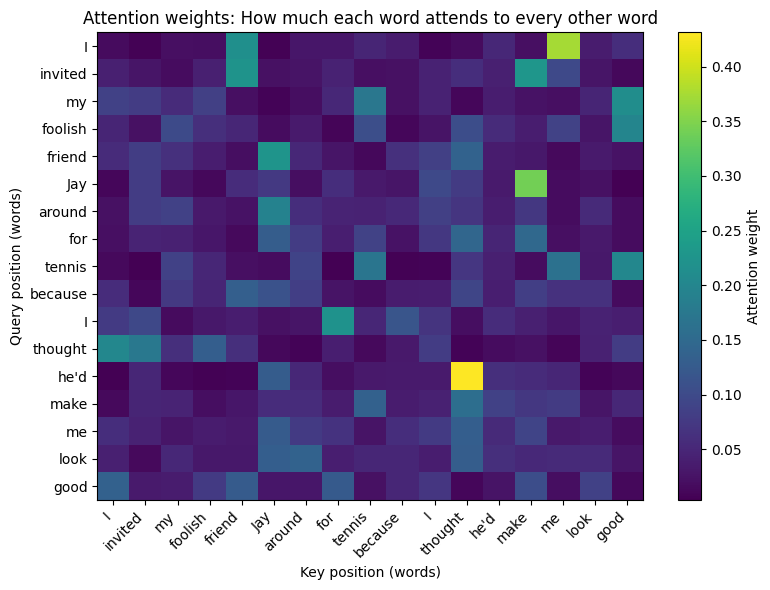

What you're seeing: Each row shows which words the model focuses on when processing a particular word.
Brighter colors = higher attention weight.


In [3]:
plt.figure(figsize=(8, 6))
plt.imshow(attn.detach().numpy(), cmap='viridis', aspect='auto')
plt.xlabel('Key position (words)')
plt.ylabel('Query position (words)')
plt.xticks(range(seq_len), words, rotation=45, ha='right')
plt.yticks(range(seq_len), words)
plt.title('Attention weights: How much each word attends to every other word')
plt.colorbar(label='Attention weight')
plt.tight_layout()
plt.show()

print("What you're seeing: Each row shows which words the model focuses on when processing a particular word.")
print("Brighter colors = higher attention weight.")


## Multi-Head Attention

We split the model dimension into `h` heads, compute attention in each, then concatenate and project. This lets the model capture different relationships in separate subspaces.

Sentence: I invited my foolish friend Jay around for tennis because I thought he'd make me look good.
Input shape: (seq_len=17, d_model=32)
Output shape: torch.Size([17, 32])
Number of attention heads: 4
Attention weights per head shape: torch.Size([17, 17])


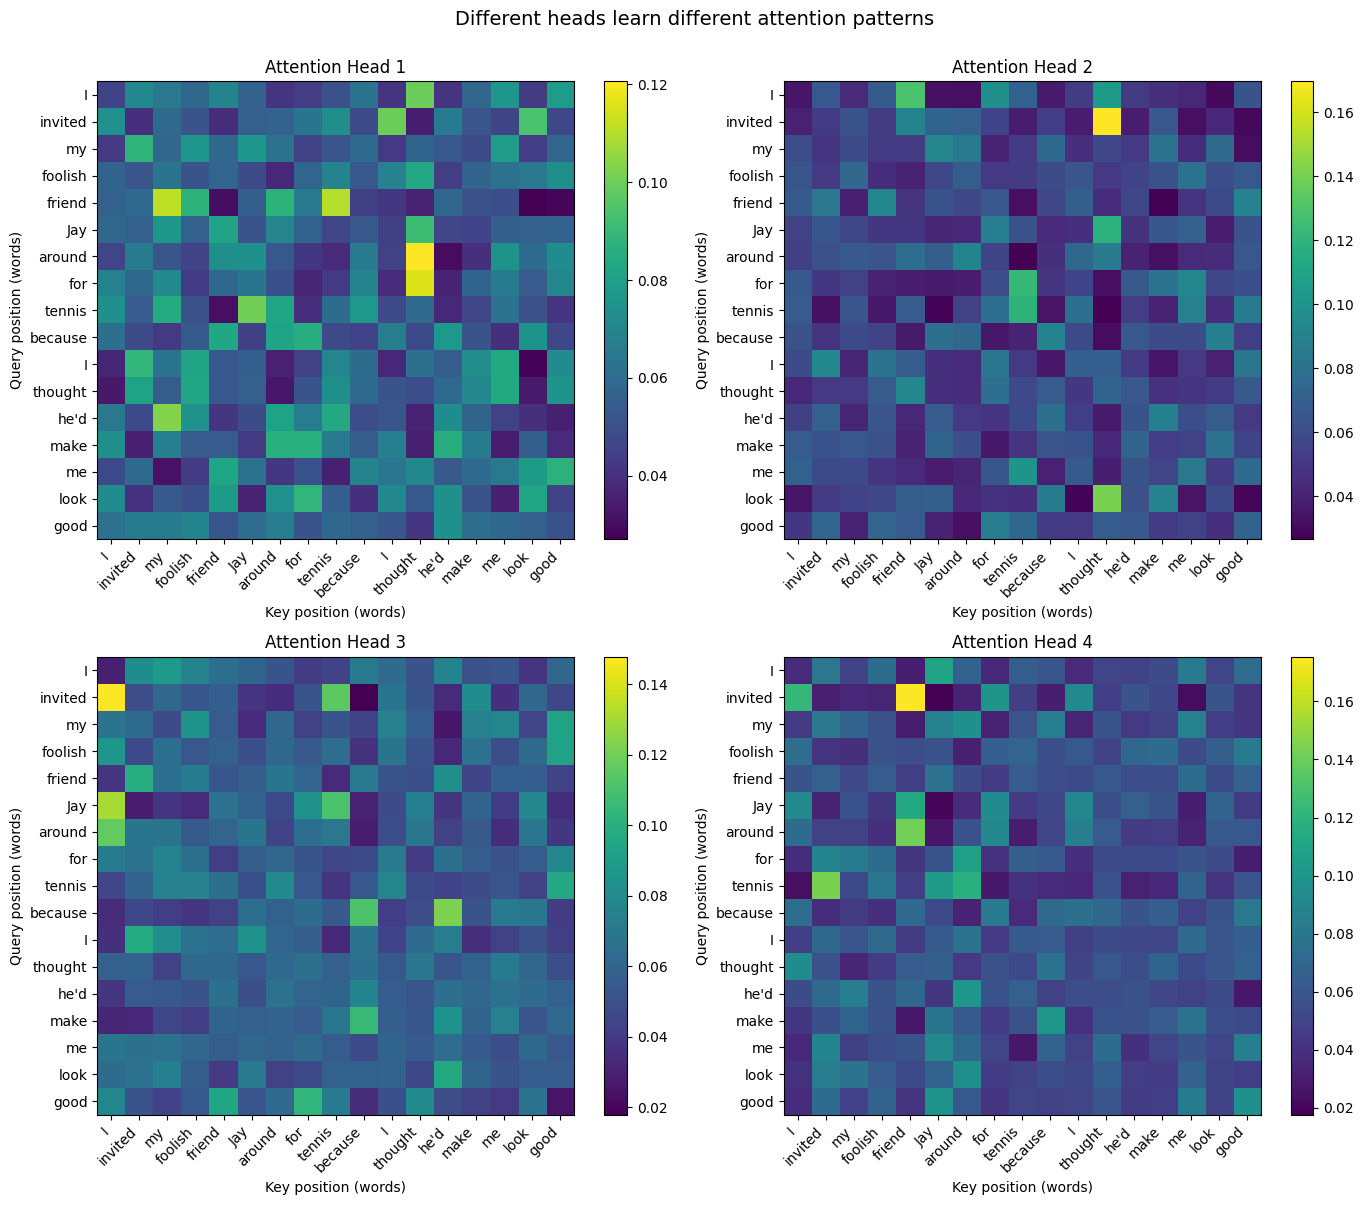


Observation: Notice how different heads focus on different relationships in the sentence!
Some heads might focus on word order, others on semantic relationships.


In [4]:
# Demo multi-head attention on the real sentence from earlier
class SimpleMultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.Wq = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wk = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wv = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wo = torch.nn.Linear(d_model, d_model, bias=False)

    def split_heads(self, x):
        seq_len = x.shape[0]
        x = x.view(seq_len, self.num_heads, self.d_head).transpose(0, 1)
        return x

    def combine_heads(self, x):
        x = x.transpose(0, 1).contiguous()
        seq_len = x.shape[0]
        return x.view(seq_len, self.d_model)

    def forward(self, x, mask=None):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        Qh = self.split_heads(Q)
        Kh = self.split_heads(K)
        Vh = self.split_heads(V)
        out_heads = []
        attn_heads = []
        for i in range(self.num_heads):
            out_i, attn_i = scaled_dot_product_attention(Qh[i], Kh[i], Vh[i], mask)
            out_heads.append(out_i)
            attn_heads.append(attn_i)
        out = torch.stack(out_heads, dim=0)
        out_combined = self.combine_heads(out)
        return self.Wo(out_combined), attn_heads

d_model = 32
num_heads = 4
mha = SimpleMultiHeadAttention(d_model, num_heads)

# Reuse the sentence we defined earlier
# Create embeddings for this sentence
torch.manual_seed(42)
x = torch.randn(len(words), d_model)  # (seq_len=3, d_model=32)

out, attn_heads = mha(x)
print(f'Sentence: {text_sentence}')
print(f'Input shape: (seq_len={len(words)}, d_model={d_model})')
print(f'Output shape: {out.shape}')
print(f'Number of attention heads: {len(attn_heads)}')
print(f'Attention weights per head shape: {attn_heads[0].shape}')

# Visualize what different heads attend to
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
for head_idx in range(min(4, num_heads)):
    ax = axes[head_idx // 2, head_idx % 2]
    attn_matrix = attn_heads[head_idx].detach().numpy()
    im = ax.imshow(attn_matrix, cmap='viridis', aspect='auto')
    ax.set_xlabel('Key position (words)')
    ax.set_ylabel('Query position (words)')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.set_title(f'Attention Head {head_idx + 1}')
    plt.colorbar(im, ax=ax)

plt.suptitle('Different heads learn different attention patterns', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\nObservation: Notice how different heads focus on different relationships in the sentence!")
print("Some heads might focus on word order, others on semantic relationships.")

## Masked (Causal) Attention

To prevent attending to future tokens, create a mask that has `-inf` (or a large negative number) for positions where key > query. We add this mask to the attention logits before `softmax`.

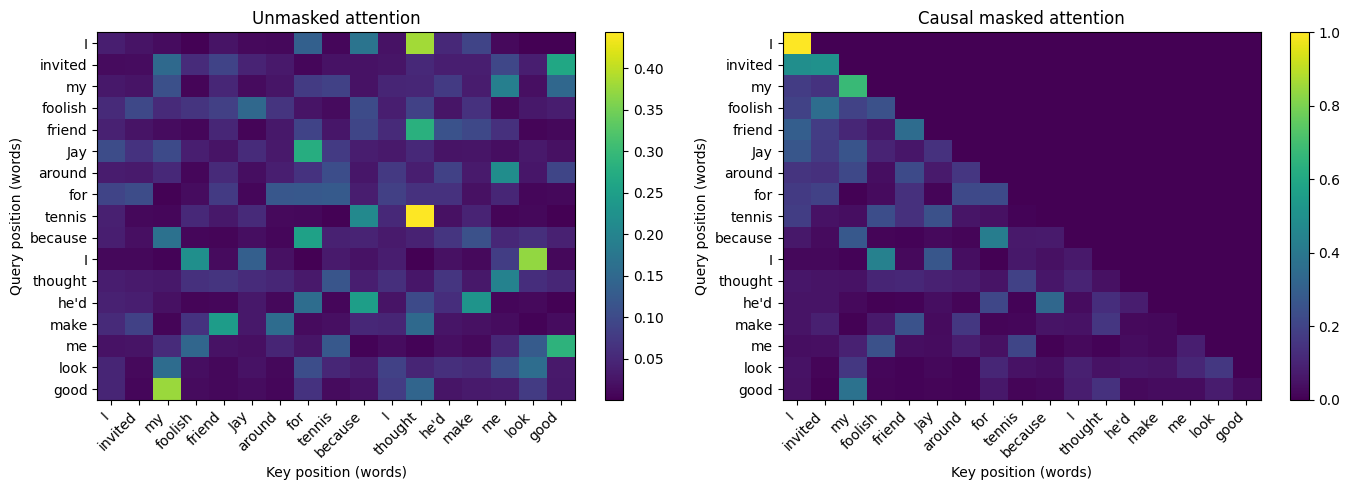

Causal masking prevents tokens from attending to future positions.
Notice the lower triangular pattern in the right plot!


In [7]:
def causal_mask(seq_len):
    # mask shape (seq_len, seq_len) with 0 for allowed, -1e9 for blocked
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1) * -1e9
    return mask

# Demonstrate causal effect using the sentence from earlier
mask = causal_mask(len(words))
Q = torch.randn(len(words), 8)
K = torch.randn(len(words), 8)
V = torch.randn(len(words), 8)
out_masked, attn_masked = scaled_dot_product_attention(Q, K, V, mask=mask)
out_unmasked, attn_unmasked = scaled_dot_product_attention(Q, K, V, mask=None)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Unmasked attention')
plt.imshow(attn_unmasked.detach().numpy(), cmap='viridis', aspect='auto')
plt.xlabel('Key position (words)')
plt.ylabel('Query position (words)')
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.yticks(range(len(words)), words)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Causal masked attention')
plt.imshow(attn_masked.detach().numpy(), cmap='viridis', aspect='auto')
plt.xlabel('Key position (words)')
plt.ylabel('Query position (words)')
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.yticks(range(len(words)), words)
plt.colorbar()

plt.tight_layout()
plt.show()

print("Causal masking prevents tokens from attending to future positions.")
print("Notice the lower triangular pattern in the right plot!")


## Using Modern Libraries (brief comparison)

At the end we show how a library uses the same primitives under the hood. The implementations are optimized, but conceptually they compute the same attention weights and combine values similarly.

Text: I invited my foolish friend Jay around for tennis because I thought he'd make me look good.
Tokenizer length: 22
Sample attention shape (layer0, head0): torch.Size([22, 22])


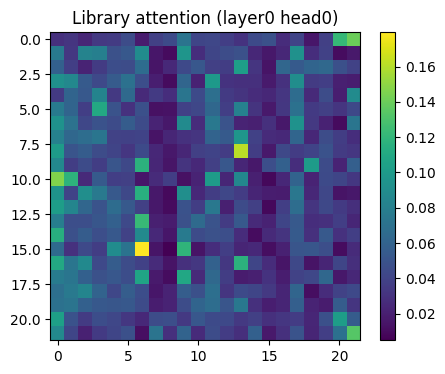

In [9]:
from transformers import AutoModel, AutoTokenizer

model_name = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

text = samples[0]['input']
enc = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**enc)
    sample_attn = outputs.attentions[0][0][0]  # layer 0, batch 0, head 0

print('Text:', text)
print('Tokenizer length:', enc['input_ids'].shape[1])
print('Sample attention shape (layer0, head0):', sample_attn.shape)

# Visualize the library attention for a single head
plt.figure(figsize=(5,4))
plt.title('Library attention (layer0 head0)')
plt.imshow(sample_attn.cpu().numpy(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()
